-----------
### CNN for actual classification (CIFAR10)

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


ship  deer  deer  plane


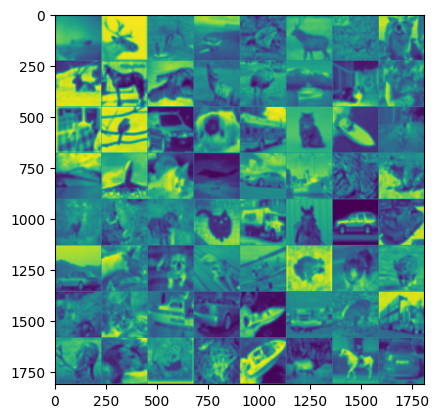

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [7]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

#### Non-accelerated CUDA training (CPU only)

In [8]:
# 1.0
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, stride=2, padding=1)  # 3x224x224 ---> 10x112x112
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x112x112 ---> 10x56x56
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=0) # 10x56x56 ---> 20x54x54
        self.fc1 = nn.Linear(20 * 27 * 27, 45)
        self.fc2 = nn.Linear(45, 45)
        self.fc3 = nn.Linear(45, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 3x224x224 ---> 10x112x112 ---> 10x56x56
        x = self.pool(F.relu(self.conv2(x))) # 10x56x56 ---> 20x54x54 ---> 20x27x27
        x = x.view(-1, 20 * 27 * 27) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 112, 112]             490
         MaxPool2d-2           [-1, 10, 56, 56]               0
            Conv2d-3           [-1, 20, 54, 54]           1,820
         MaxPool2d-4           [-1, 20, 27, 27]               0
            Linear-5                   [-1, 45]         656,145
            Linear-6                   [-1, 45]           2,070
            Linear-7                   [-1, 10]             460
Total params: 660,985
Trainable params: 660,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 1.75
Params size (MB): 2.52
Estimated Total Size (MB): 4.85
----------------------------------------------------------------
Epochs 1   train loss 2.17092 train acc 0.20018 validate loss 1.87290 validate acc 0.34040
---------------

C:\Users\AVI003\AppData\Local\Temp\ipykernel_31568\3436101493.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


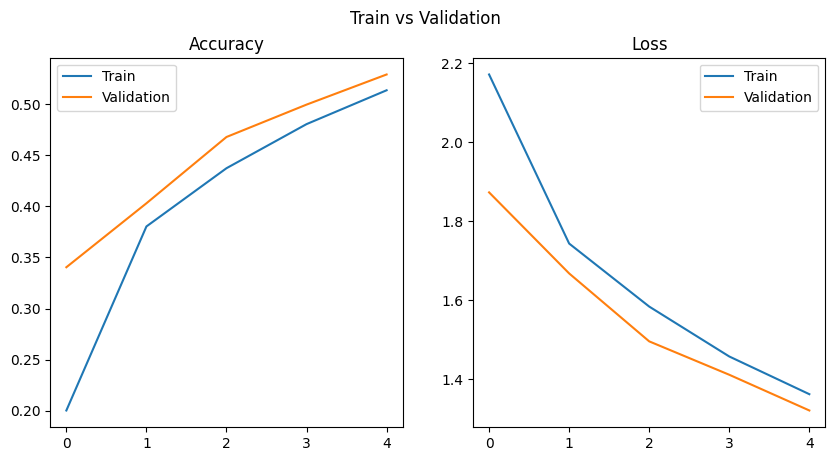

In [9]:
plot_graph(training_logs)

In [10]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

[(test loss: 1.32159423828125] [accuracy_test: 52.839999999999996 %]


In [ ]:
# 1.1 Conv-Conv-Pool 
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)  # 3x224x224 -> 10x224x224
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)  # 10x224x224 -> 10x224x224
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x224x224 -> 10x112x112
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)  # 10x112x112 -> 20x112x112
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)  # 20x112x112 -> 20x112x112

        # Fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56, 45)
        self.fc2 = nn.Linear(45, 45)
        self.fc3 = nn.Linear(45, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(self.conv1(x)))) # 3x224x224 -> 10x224x224 -> 10x112x112
        x = self.pool(F.relu(self.conv4(self.conv3(x)))) # 10x112x112 -> 20x112x112 -> 20x56x56
        x = x.view(-1, 20 * 56 * 56) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 224, 224]             280
            Conv2d-2         [-1, 10, 224, 224]             910
         MaxPool2d-3         [-1, 10, 112, 112]               0
            Conv2d-4         [-1, 20, 112, 112]           1,820
            Conv2d-5         [-1, 20, 112, 112]           3,620
         MaxPool2d-6           [-1, 20, 56, 56]               0
            Linear-7                   [-1, 45]       2,822,445
            Linear-8                   [-1, 45]           2,070
            Linear-9                   [-1, 10]             460
Total params: 2,831,605
Trainable params: 2,831,605
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 12.92
Params size (MB): 10.80
Estimated Total Size (MB): 24.30
------------------------------------

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

In [ ]:
# 1.2 Conv-Conv-Conv-Pool
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)  # 3x224x224 -> 10x224x224
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=2, padding=1)  # 10x224x224 -> 10x112x112
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)  # 10x112x112 -> 10x112x112
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x112x112 -> 10x56x56
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)  # 10x56x56 -> 20x56x56
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=2, padding=1)  # 20x56x56 -> 20x28x28
        self.conv6 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)  # 20x28x28 -> 20x28x28
        self.fc1 = nn.Linear(20 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv3(self.conv2(self.conv1(x))))) # 3x224x224 -> 10x224x224 -> 10x112x112 -> 10x56x56
        x = self.pool(F.relu(self.conv6(self.conv5(self.conv4(x))))) # 10x56x56 -> 20x56x56 -> 20x28x28 -> 20x14x14
        x = x.view(-1, 20 * 14 * 14) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

In [ ]:
# 1.3 Conv(stride=1)-Conv(Stride=1)-Conv(Stride=1)-Pool
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)  # 3x224x224 -> 10x224x224
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)  # 10x224x224 -> 10x224x224
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)  # 10x224x224 -> 10x224x224
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x224x224 -> 10x112x112
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)  # 10x112x112 -> 20x112x112
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)  # 20x112x112 -> 20x112x112
        self.conv6 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)  # 20x112x112 -> 20x112x112
        self.fc1 = nn.Linear(20 * 56 * 56, 45)
        self.fc2 = nn.Linear(45, 45)
        self.fc3 = nn.Linear(45, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv3(self.conv2(self.conv1(x))))) # 3x224x224 -> 10x224x224 -> 10x112x112
        x = self.pool(F.relu(self.conv6(self.conv5(self.conv4(x))))) # 10x112x112 -> 20x112x112 -> 20x56x56
        x = x.view(-1, 20 * 56 * 56) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

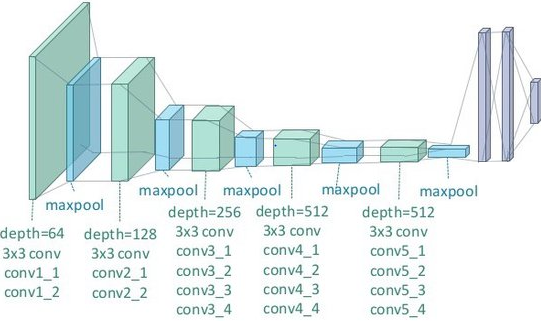

In [ ]:
# 1.4
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)  # 3x224x224 ---> 32x222x222
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)  # 32x222x222 ---> 64x220x220
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)  # 64x110x110 --->  128x108x108
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)  # 64x108x108 ---> 64x106x106
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)  # 128x53x53 ---> 256x51x51
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)  # 256x51x51 ---> 256x49x49
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)  # 256x49x49 ---> 256x47x47
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)  # 256x47x47 ---> 256x45x45
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0)  # 256x45x45 ---> 512x43x43
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x43x43 ---> 512x41x41
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x41x41 ---> 512x39x39
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x39x39 ---> 512x37x37
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x37x37 ---> 512x35x35
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x35x35 ---> 512x33x33
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x33x33 ---> 512x31x31
        self.conv5_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0)  # 512x31x31 ---> 512x29x29
        self.fc1 = nn.Linear(512 * 29 * 29, 45)
        self.fc2 = nn.Linear(45, 45)
        self.fc3 = nn.Linear(45, 10)

    def forward(self, x):
        x = self.relu(self.conv1_2(self.conv1_1(x))) 
        x = self.pool1(x) # 64x220x220 ---> 64x110x110 
        x = self.relu(self.conv2_2(self.conv2_1(x))) 
        x = self.pool1(x) # 64x106x106 ---> 64x53x53
        x = self.relu(self.conv3_4(self.conv3_3(self.conv3_2(self.conv3_1(x))))) 
        x = self.pool2(x) # 256x45x45 ---> 256x45x45
        x = self.relu(self.conv4_4(self.conv4_3(self.conv4_2(self.conv4_1(x))))) 
        x = self.pool2(x) # 512x37x37 ---> 512x37x37
        x = self.relu(self.conv5_4(self.conv5_3(self.conv5_2(self.conv5_1(x))))) 
        x = self.pool2(x) # 512x29x29 ---> 512x29x29
        x = x.view(-1, 512 * 29 * 29) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

#### Accelerated CUDA training (GPU-T4)

In [ ]:
# import os
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary
# import time

# #---Variable initialization---
# torch.manual_seed(42)
# #vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# #vvvvvvv Add this term vvvvvvvv
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# #-----------------------------

# # PyTorch models inherit from torch.nn.Module
# #---CNN---
# class DeepModelT4(nn.Module):
#     def __init__(self):
#         super(DeepModelT4, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, stride=2, padding=1)  # 1x32x32 ---> 10x16x16
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x16x16 ---> 10x8x8
#         self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=0) # 10x8x8 ---> 20x6x6
#         self.fc1 = nn.Linear(20 * 3 * 3, 128)
#         self.fc2 = nn.Linear(128, 32)
#         self.fc3 = nn.Linear(32, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 20 * 3 * 3)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Model init
# model = DeepModelT4().to(device)
# summary(model, (3, 32, 32))

# # Loss function
# loss_fn = torch.nn.CrossEntropyLoss()
# # Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Initializing in a separate cell so we can easily add more epochs to the same run
# # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# # writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 5
# path_save_cp = './cp/'
# best_vloss = 1_000_000.
# training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

# t_0_accelerated = time.time()
# for epoch in range(EPOCHS):
#     train_loss, train_correct = 0, 0
#     # Make sure gradient tracking is on, and do a pass over the data
#     model.train(True)
#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(training_loader):
#         # Every data instance is an input + label pair
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         train_loss += loss.item()
#         train_correct += (outputs.argmax(1) == labels).float().sum().item()

#     training_logs["train_loss"].append(train_loss / len(training_loader))
#     training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

#     running_vloss = 0.0
#     # Set the model to evaluation mode, disabling dropout and using population
#     # statistics for batch normalization.
#     model.eval()
#     # Disable gradient computation and reduce memory consumption.
#     valid_loss, valid_correct = 0, 0
#     with torch.no_grad():
#         for i, vdata in enumerate(validation_loader):
#             vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
#             voutputs = model(vinputs)
#             vloss = loss_fn(voutputs, vlabels)
#             valid_loss += loss_fn(voutputs, vlabels).item()
#             valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
#         # save validation logs
#         training_logs["validate_loss"].append(valid_loss / len(validation_loader))
#         training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

#     if epoch % 1 == 0:
#         print(f"Epochs {epoch+1}".ljust(10),
#             f"train loss {training_logs['train_loss'][-1]:.5f}",
#             f"train acc {training_logs['train_acc'][-1]:.5f}",

#             f"validate loss {training_logs['validate_loss'][-1]:.5f}",
#             f"validate acc {training_logs['validate_acc'][-1]:.5f}",
#             )
#         print("-"*80)

#     # Track best performance, and save the model's state
#     if valid_loss < best_vloss:
#         best_vloss = valid_loss
#         # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
#         torch.save(model.state_dict(), path_save_cp+'best_model.pth')

#     epoch_number += 1

# t_end_accelerated = time.time()-t_0_accelerated
# print(f"Time consumption for accelerated CUDA training (T4): {t_end_accelerated} sec")

In [ ]:
# plot_graph(training_logs)

In [ ]:
# # Inference phase
# PATH = './cp/best_model.pth'
# loaded_model = DeepModelT4()
# loaded_model.load_state_dict(torch.load(PATH))
# acc_test = 0
# test_loss = 0
# loaded_model.to(device).eval()
# stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
# for i, tdata in enumerate(validation_loader):
#     tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
#     toutputs = loaded_model(tinputs)
#     loss = loss_fn(toutputs, tlabels)
#     test_loss += loss
#     # Argmax one-hot pred to class vector
#     _, preds_t = torch.max(toutputs, 1)
#     acc_test += (preds_t == tlabels).float().mean().item()
#     # Store vec
#     stored_lbs = torch.cat((stored_lbs, tlabels), 0)
#     stored_preds = torch.cat((stored_preds, preds_t), 0)

# accuracy_t = round(acc_test / float(len(validation_loader)), 4)
# avg_tloss = test_loss / (i + 1)
# print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

#### Additional Quantitative Matrics

In [ ]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

--------
#Homework\
1.) จงออกแบบโมเดลเพิ่อรองรับขนาดภาพแบบ (3 x 224 x 224)

```
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    |
    | เปลี่ยนฟังก์ชั่น transform เป็น
    |
    V
transform = transforms.Compose(
    [transforms.Resize((224, 224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
```

ที่มีโมเดลใหม่จากเดิมใช้เป็น Conv-Pool ต่อ 1 ชั้นจากเดิม เปลี่ยนเป็น

- <1.1> Conv-Conv-Pool ต่อ 1 ชั้น (สูงสุด 2 ชั้น, กำหนด Filter/Stride/Padding เอง)
- <1.2> Conv-Conv-Conv-Pool ต่อ 1 ชั้น (สูงสุด 2 ชั้น, กำหนด Filter/Stride/Padding เอง)
- <1.3> Conv(stride=1)-Conv(Stride=1)-Conv(Stride=1)-Pool ต่อ 1 ชั้น (สูงสุด 2 ชั้น, กำหนด Filter/Padding เอง)
- <1.4> จำนวนชั้นเป็นไปตามรูปตัวอย่างข้างใต้ (Stride=1)

ทำการเปรียบเทียบ วิเคราะห์ และอภิปรายผลว่าการปรับใช้ Conv-Pool สำหรับโมเดลที่ลึกขึ้นและกว้างขึ้น (Wider & Deeper) มีผลเป็นอย่างไร
\
\
\
\
ตัวอย่างโค้ดโมเดล
```
class WiderDeeperNet(nn.Module):
    def __init__(self):
        super(WiderDeeperNet, self).__init__()
        
        self.pool = ...
        #-----In case: Conv-Conv-Pool----
        self.conv1_1 = ...
        self.conv1_2 = ...
        self.conv2_1 = ...
        self.conv2_2 = ...
        #--------------------------------

        self.fc1 = nn.Linear(C * H * W, จำนวนโหนดเป็นรหัสนศ. 3 ตัวท้าย)
        self.fc2 = nn.Linear(จำนวนโหนดเป็นรหัสนศ. 3 ตัวท้าย, จำนวนโหนดเป็นรหัสนศ. 3 ตัวท้าย)
        self.fc3 = nn.Linear(จำนวนโหนดเป็นรหัสนศ. 3 ตัวท้าย, 10)

  def forward(self, x):

        #--------In case: Conv-Conv-Pool------
        x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))
        #-------------------------------------

        x = x.view(-1, C * H * W)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

ตัวอย่าง <1.4> และชั้นตัวอย่างการสร้างแบบ Conv-Conv-...-Pool ต่อ 1 ชั้น\
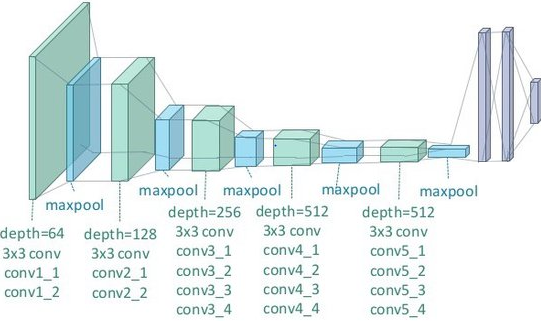
\
\
\
\
\
2.) ลองปรับโครงสร้างโมเดลส่วนสกัดภาพ (Feature Extractor; Conv-Pool block) จาก (1.1-1.4) โดยให้โมเดลเรียนรู้ของเราสามารถเรียนรู้ได้ประสิทธิภาพมากกว่าหรือใกล้กับ **ความแม่นยำ 90 %**
- กำหนดให้สามารถปรับแต่ง Optimizer, learning rate, weight decay, loss function, activation function แบบใหม่, รอบการฝึกฝน (Epoches) ฯลฯ ตามอิสระ
- กำหนดให้ทำการฝึกฝน (Training) โมเดล ใช้ CPU และ GPU T4 บันทึกผลจากทั้ง 2 วิธีการ

<2.1> โมเดลที่ออกแบบมาเป็นแบบใด และมีการตั้งค่า Hyper-parameter เป็นอย่างไร ?\
<2.2> ทั้ง 2 โมเดลใช้ทรัพยากรทั้งจำนวนพารามิเตอร์หรือเวลาการฝึกฝนต่างกันเพียงใด ?